In [74]:
import os, time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from skimage.feature import *

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50V2, InceptionV3
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/'
normal_images_dir = os.path.join(base_dir, 'normal')
ghibli_images_dir = os.path.join(base_dir, 'ghibli')

print(f"Path to normal images folder: {normal_images_dir}")
print(f"Path to Ghibli images folder: {ghibli_images_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path to normal images folder: /content/drive/MyDrive/normal
Path to Ghibli images folder: /content/drive/MyDrive/ghibli


# DL models

In [16]:
# Define input params
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, 3)
num_classes=2

def load_and_preprocess_data(normal_dir, ghibli_dir, img_size=(IMG_SIZE, IMG_SIZE)):
    """Loads images from directories, preprocesses them, and creates labels."""
    images = []
    labels = []

    for filename in os.listdir(normal_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                img_path = os.path.join(normal_dir, filename)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                img_array = img_array / 255.0  # Normalize pixel values
                images.append(img_array)
                labels.append(0)  # Label 0 for normal images
            except Exception as e:
                print(f"Error loading or preprocessing normal image {filename}: {e}")

    for filename in os.listdir(ghibli_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                img_path = os.path.join(ghibli_dir, filename)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                img_array = img_array / 255.0    # Normalize pixel values
                images.append(img_array)
                labels.append(1)                 # Label 1 for Ghibli images
            except Exception as e:
                print(f"Error loading or preprocessing Ghibli image {filename}: {e}")

    return np.array(images), np.array(labels)

def augm_fit_model(model, train_data, train_labels, val_data, val_labels, epochs=10, batch_size=32):
    """Trains the model using data augmentation."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(train_data)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
                  metrics=['accuracy'])

    history = model.fit(
        datagen.flow(train_data, train_labels, batch_size=batch_size),
        steps_per_epoch=len(train_data) // batch_size,
        validation_data=(val_data, val_labels),
        epochs=epochs
    )
    return history

def evaluate_model(model, test_data, test_labels, name):
    """Evaluates the trained model on the test data."""
    loss, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    y_pred_probs = model.predict(test_data)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print(f"\n{name} Classification Report:")
    print(classification_report(test_labels, y_pred, target_names=['Normal', 'Ghibli']))

    cm = confusion_matrix(test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ghibli'], yticklabels=['Normal', 'Ghibli'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

def train_models(model, name):
    print(f"\nTraining {name}...\n")
    # Train the model
    history = augm_fit_model(model, X_train, y_train, X_val, y_val, epochs=20)
    evaluate_model(model, X_test, y_test, name)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{name} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{name} Loss')
    plt.show()

    model.save(f'{name}_ghibli_normal.h5')
    print(f"Trained model saved as {name}_ghibli_normal.h5")

def build_model(input_shape, num_classes, model_name):
    """Builds an efficient image classification model using MobileNetV3Small."""
    input_tensor = Input(shape=input_shape)
    if model_name == 'Mobilenet':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    elif model_name == 'Efficientnet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
    elif model_name == 'Resnet':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)
    elif model_name == 'Inception':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class

    model = Model(inputs=input_tensor, outputs=output_tensor)
    train_models(model, model_name)

In [5]:
# Load and preprocess data
images, labels = load_and_preprocess_data(normal_images_dir, ghibli_images_dir)

# split in train, val, test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

<ipython-input-4-bc0ad7938e24>:111: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training Mobilenet...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 587ms/step - accuracy: 0.7362 - loss: 0.5523 - val_accuracy: 0.8948 - val_loss: 0.2575
Epoch 2/20
 1/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9688 - loss: 0.2402

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9688 - loss: 0.2402 - val_accuracy: 0.8990 - val_loss: 0.2567
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.9150 - loss: 0.2336 - val_accuracy: 0.8825 - val_loss: 0.2502
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8438 - loss: 0.2644 - val_accuracy: 0.8866 - val_loss: 0.2569
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 503ms/step - accuracy: 0.9126 - loss: 0.2034 - val_accuracy: 0.9196 - val_loss: 0.2180
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8125 - loss: 0.3975 - val_accuracy: 0.9175 - val_loss: 0.2166
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 366ms/step - accuracy: 0.9121 - loss: 0.2077 - val_accuracy: 0.9155 - val_loss: 0.2188
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.1345 - val_accuracy: 0.9072 - val_loss: 0.2346
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 380ms/step - accuracy: 0.9317 - loss: 0.1711 - val_accuracy: 0.9052 - val_

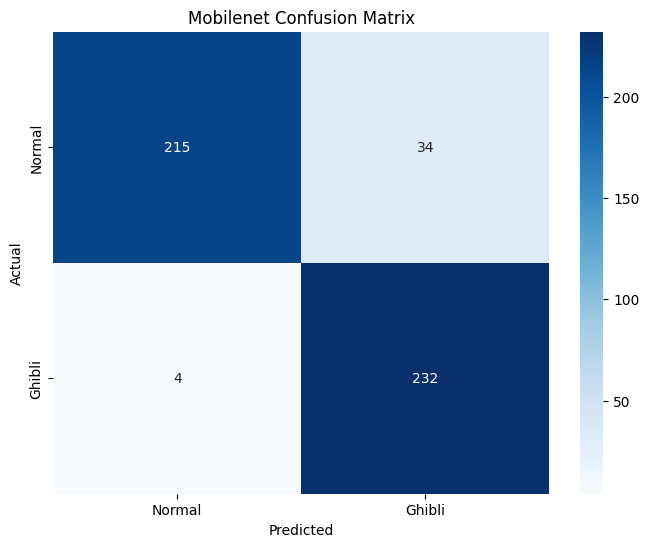

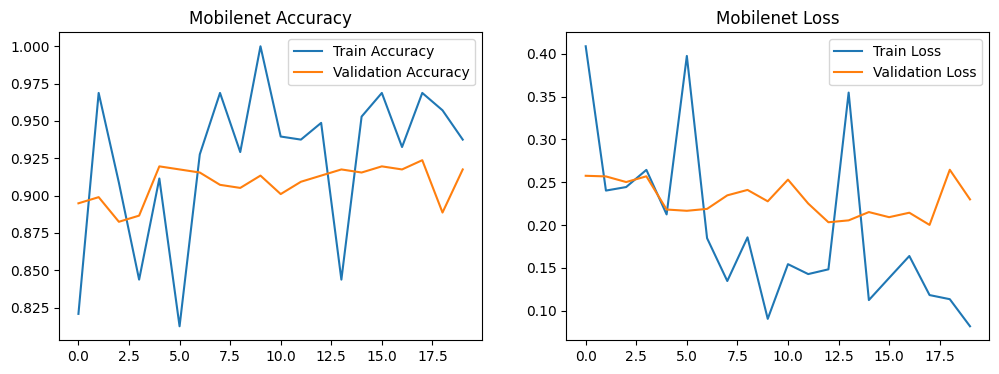

Trained model saved as Mobilenet_ghibli_normal.h5


In [6]:
build_model(input_shape, num_classes, 'Mobilenet')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training Efficientnet...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 59s 843ms/step - accuracy: 0.4835 - loss: 0.7478 - val_accuracy: 0.4866 - val_loss: 0.6976
Epoch 2/20
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5625 - loss: 0.6889

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5625 - loss: 0.6889 - val_accuracy: 0.4866 - val_loss: 0.6940
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 51s 405ms/step - accuracy: 0.5163 - loss: 0.6954 - val_accuracy: 0.4866 - val_loss: 0.6944
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5938 - loss: 0.6900 - val_accuracy: 0.4866 - val_loss: 0.6963
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.5016 - loss: 0.6997 - val_accuracy: 0.4866 - val_loss: 0.6940
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4062 - loss: 0.6974 - val_accuracy: 0.5134 - val_loss: 0.6928
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 408ms/step - accuracy: 0.4971 - loss: 0.6997 - val_accuracy: 0.5134 - val_loss: 0.6932
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5000 - loss: 0.6896 - val_accuracy: 0.5134 - val_loss: 0.6934
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 366ms/step - accuracy: 0.5011 - loss: 0.6994 - val_accuracy: 0.4866 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


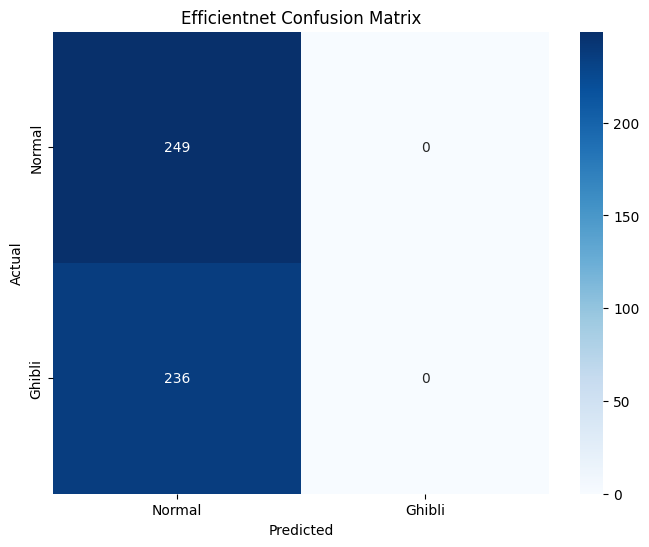

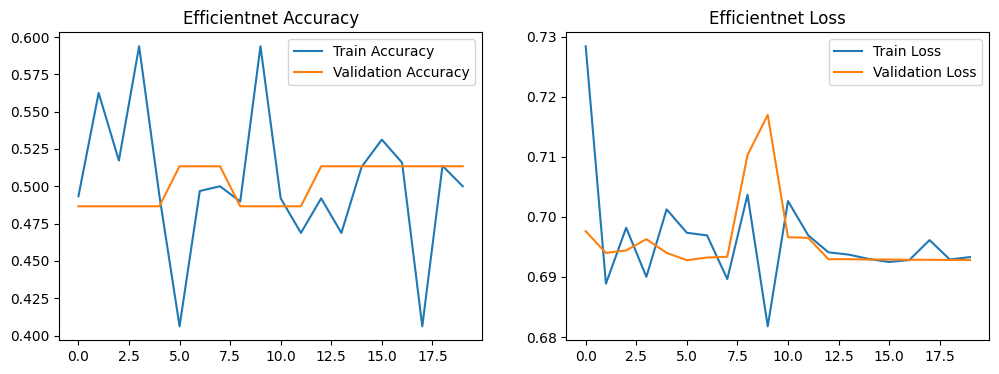

Trained model saved as Efficientnet_ghibli_normal.h5


In [7]:
build_model(input_shape, num_classes, 'Efficientnet')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Training Resnet...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 675ms/step - accuracy: 0.8071 - loss: 0.4614 - val_accuracy: 0.8948 - val_loss: 0.2534
Epoch 2/20
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9375 - loss: 0.1591

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9375 - loss: 0.1591 - val_accuracy: 0.8825 - val_loss: 0.2658
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step - accuracy: 0.9066 - loss: 0.2269 - val_accuracy: 0.9175 - val_loss: 0.2215
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9062 - loss: 0.2442 - val_accuracy: 0.9196 - val_loss: 0.2171
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 398ms/step - accuracy: 0.9411 - loss: 0.1527 - val_accuracy: 0.9196 - val_loss: 0.1882
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9688 - loss: 0.0790 - val_accuracy: 0.9299 - val_loss: 0.1834
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 399ms/step - accuracy: 0.9459 - loss: 0.1604 - val_accuracy: 0.9320 - val_loss: 0.2014
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 0.0392 - val_accuracy: 0.9361 - val_loss: 0.2255
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 395ms/step - accuracy: 0.9456 - loss: 0.1352 - val_accuracy: 0.9402 - val_

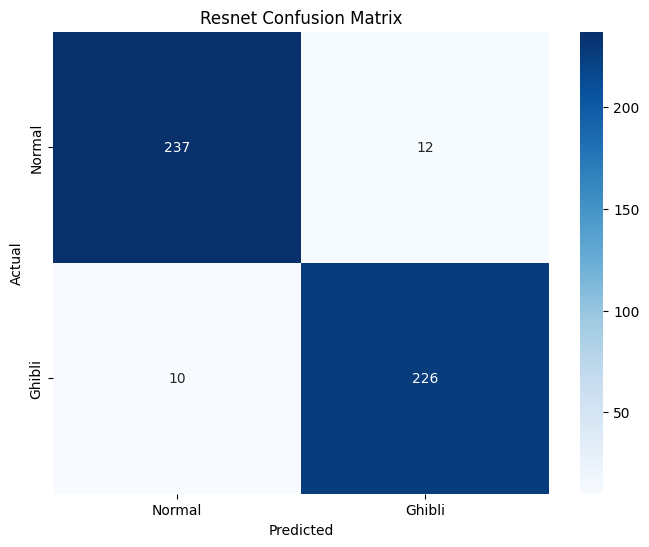

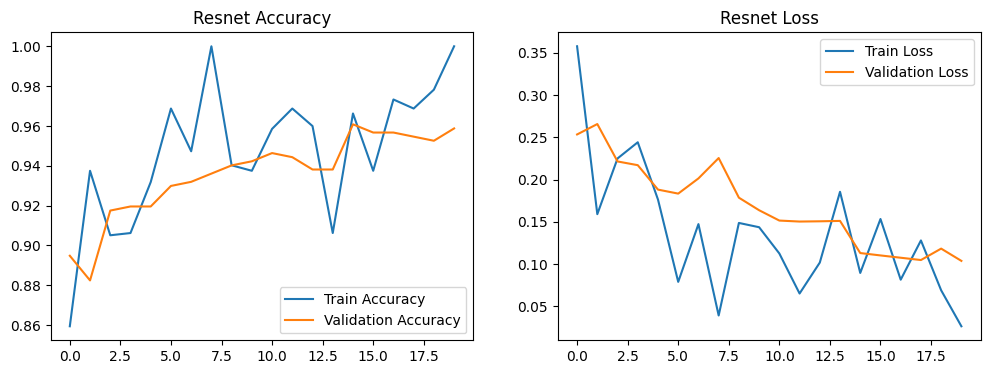

Trained model saved as Resnet_ghibli_normal.h5


In [8]:
build_model(input_shape, num_classes, 'Resnet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training Inception...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 807ms/step - accuracy: 0.7063 - loss: 0.6662 - val_accuracy: 0.8515 - val_loss: 0.3402
Epoch 2/20
 1/45 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.9688 - loss: 0.1948

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9688 - loss: 0.1948 - val_accuracy: 0.8474 - val_loss: 0.3335
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 400ms/step - accuracy: 0.8788 - loss: 0.3055 - val_accuracy: 0.8804 - val_loss: 0.3060
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9688 - loss: 0.1750 - val_accuracy: 0.8928 - val_loss: 0.2910
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 605ms/step - accuracy: 0.8822 - loss: 0.2863 - val_accuracy: 0.8701 - val_loss: 0.2810
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9375 - loss: 0.1991 - val_accuracy: 0.8804 - val_loss: 0.2668
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 420ms/step - accuracy: 0.8913 - loss: 0.2686 - val_accuracy: 0.9196 - val_loss: 0.2390
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8750 - loss: 0.2462 - val_accuracy: 0.9113 - val_loss: 0.2419
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 402ms/step - accuracy: 0.8949 - loss: 0.2336 - val_accuracy: 0.8990 - val_

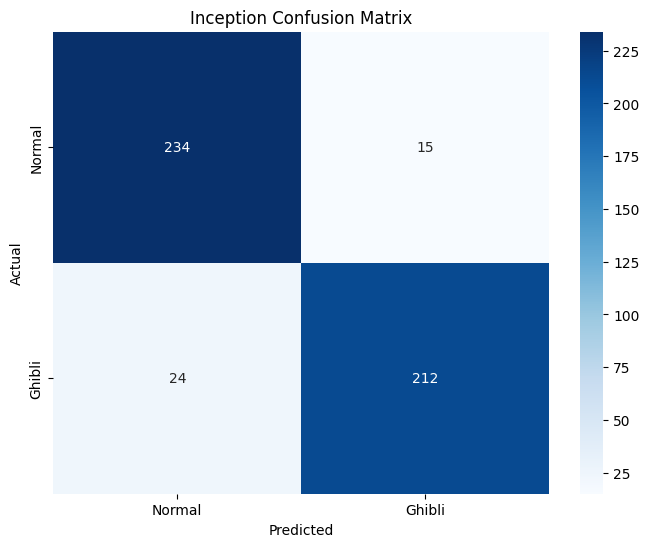

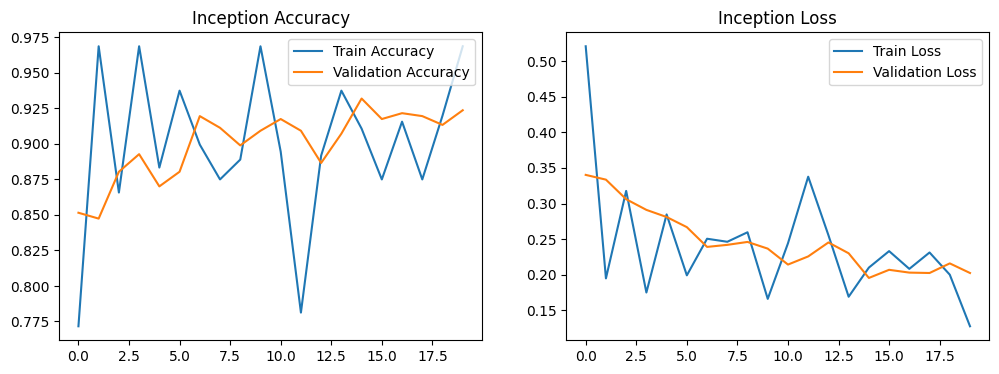

Trained model saved as Inception_ghibli_normal.h5


In [9]:
build_model(input_shape, num_classes, 'Inception')

In [ ]:
# Load the best model
try:
    model = load_model('<name>.h5')
    print("Trained model loaded successfully.")
except FileNotFoundError:
    print("Error: The model file was not found. Make sure the model is saved in the same directory or provide the correct path.")
    model = None

In [46]:
# Define the filenames of your models
model_filenames = [
    '/content/Mobilenet_ghibli_normal.h5',
    '/content/Efficientnet_ghibli_normal.h5',
    '/content/Resnet_ghibli_normal.h5',
    '/content/Inception_ghibli_normal.h5'
]

loaded_models = []
model_names = []
test_accuracies = []
inference_times = []

# --- Load the models and evaluate their performance ---
for filename in model_filenames:
    try:
        model = load_model(filename)
        print(f"Model '{filename}' loaded successfully.")
        loaded_models.append(model)

        # Extract model name for plotting
        model_name_short = (filename.replace('/content/', '')).replace('_ghibli_normal.h5', '')
        model_names.append(model_name_short)

        start_time = time.time()
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0) # Set verbose to 0
        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)
        test_accuracies.append(accuracy)
        print(f"Test accuracy for '{filename}': {accuracy:.4f}, Inference time: {inference_time:.4f} seconds")

    except FileNotFoundError:
        print(f"Error: Model file '{filename}' not found.")
        loaded_models.append(None)
        model_names.append(filename.replace('.h5', ''))
        test_accuracies.append(None)
        inference_times.append(None)
    except Exception as e:
        print(f"Error loading model '{filename}': {e}")
        loaded_models.append(None)
        model_names.append(filename.replace('.h5', ''))
        test_accuracies.append(None)
        inference_times.append(None)

Model '/content/Mobilenet_ghibli_normal.h5' loaded successfully.
Test accuracy for '/content/Mobilenet_ghibli_normal.h5': 0.9216, Inference time: 7.0524 seconds


Model '/content/Efficientnet_ghibli_normal.h5' loaded successfully.
Test accuracy for '/content/Efficientnet_ghibli_normal.h5': 0.5134, Inference time: 12.7238 seconds


Model '/content/Resnet_ghibli_normal.h5' loaded successfully.
Test accuracy for '/content/Resnet_ghibli_normal.h5': 0.9546, Inference time: 8.5617 seconds


Model '/content/Inception_ghibli_normal.h5' loaded successfully.
Test accuracy for '/content/Inception_ghibli_normal.h5': 0.9196, Inference time: 10.9187 seconds


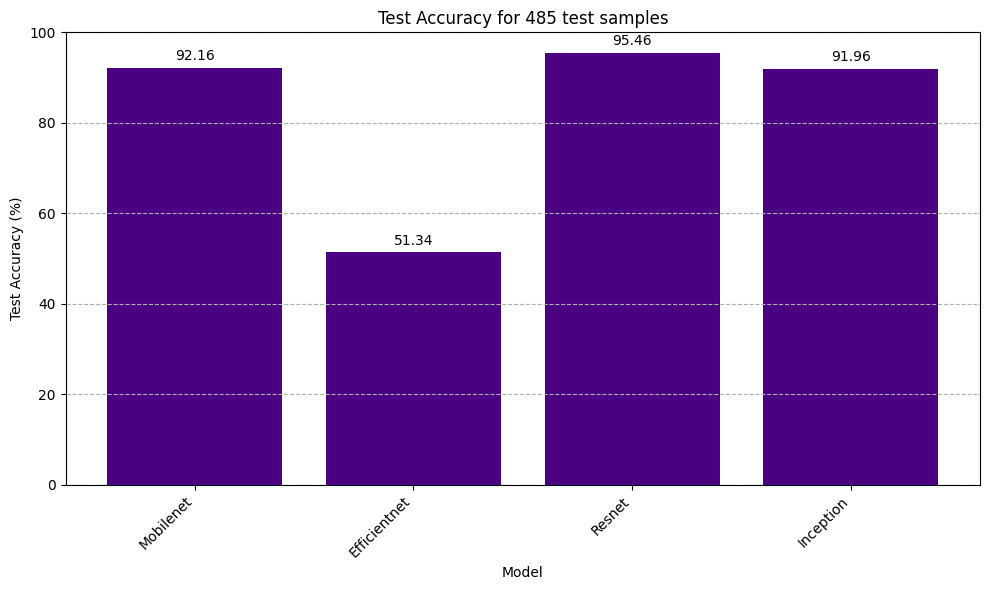

In [62]:
# --- Bar Plot of Test Performance ---
# Filter out None values for plotting
valid_accuracies = [acc for acc in test_accuracies if acc is not None]
valid_model_names = [name for i, name in enumerate(model_names) if test_accuracies[i] is not None]

# Only plot if we have some valid data
if valid_model_names:
    accuracies_percentage = [acc * 100 for acc in valid_accuracies]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(valid_model_names, accuracies_percentage, color='indigo')
    plt.xlabel('Model')
    plt.ylabel('Test Accuracy (%)')
    plt.title(f'Test Accuracy for {y_test.shape[0]} test samples')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--')
    plt.xticks(rotation=45, ha='right')

    # Add accuracy values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("No models were loaded and evaluated successfully, so no plot can be generated.")

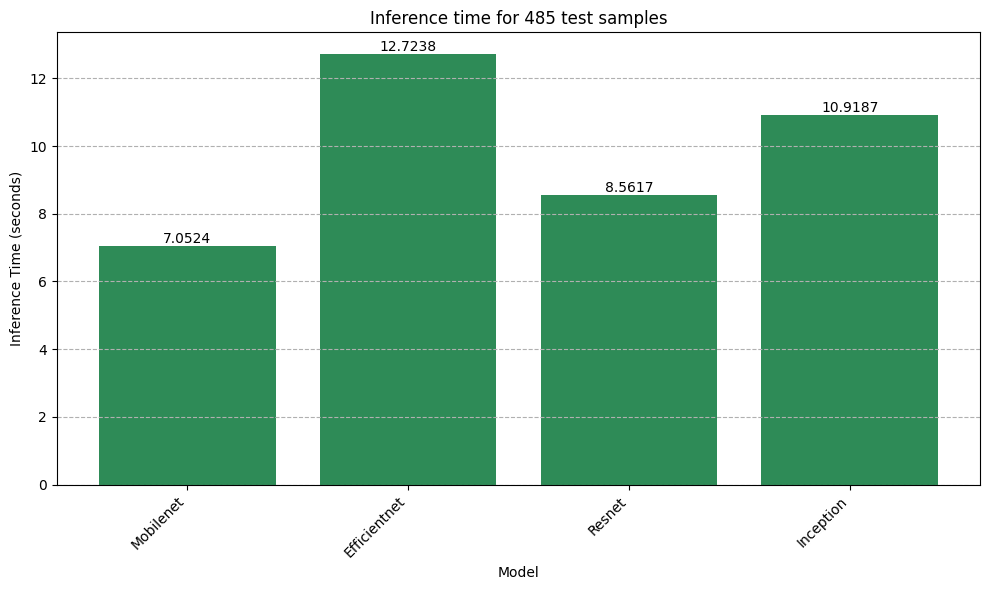

In [61]:
# --- Bar Plot of Inference Time ---
# Filter out None values for plotting
valid_inference_times = [time for time in inference_times if time is not None]
valid_model_names_time = [name for i, name in enumerate(model_names) if inference_times[i] is not None]

# Only plot if we have some valid data
if valid_model_names_time:
    plt.figure(figsize=(10, 6))
    bars_time = plt.bar(valid_model_names_time, valid_inference_times, color='seagreen')
    plt.xlabel('Model')
    plt.ylabel('Inference Time (seconds)')
    plt.title(f'Inference time for {y_test.shape[0]} test samples')
    plt.grid(axis='y', linestyle='--')
    plt.xticks(rotation=45, ha='right')

    # Add inference time values on top of the bars
    for bar in bars_time:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}', ha='center', va='bottom') # Adjust spacing as needed

    plt.tight_layout()
    plt.show()
else:
    print("No models were loaded and their inference time could be measured successfully, so no plot can be generated.")

In [66]:
# Time + accuracy -> Resnet
best_dl_model = load_model('/content/Resnet_ghibli_normal.h5')

In [71]:
def predict_image(image_path, model):
    if best_dl_model is None:
        return "No model loaded. Cannot make prediction."

    try:
        img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)   # Create a batch of size 1
        img_array /= 255.0                              # Normalize the image

        prediction = best_dl_model.predict(img_array)

        if prediction[0][1] > 0.5:                      # Probability of being Ghibli (index 1)
            return "Ghibli"
        else:
            return "Not Ghibli"

    except FileNotFoundError:
        return f"Error: Image not found at path: {image_path}"
    except Exception as e:
        return f"Error processing image: {e}";

test_image = '/content/test_00.png'
prediction = predict_image(test_image, best_dl_model)
print(f"Prediction for '{test_image}': {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction for '/content/test_00.png': Not Ghibli


# Try ML models

In [75]:
# Define image size for resizing before feature extraction
IMG_SIZE = 128

# Define HOG parameters
HOG_PARAMS = {'orientations': 8,
              'pixels_per_cell': (16, 16),
              'cells_per_block': (1, 1),
              'block_norm': 'L2-Hys'}

def load_and_extract_features(normal_dir, ghibli_dir, img_size=(IMG_SIZE, IMG_SIZE), hog_params=HOG_PARAMS):
    """Loads images, resizes them, and extracts HOG features."""
    features = []
    labels = []

    for label, img_dir in enumerate([normal_dir, ghibli_dir]):
        for filename in os.listdir(img_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(img_dir, filename)
                    img = Image.open(img_path).convert('RGB')  # Ensure RGB
                    img_resized = img.resize(img_size)
                    img_array = np.array(img_resized)

                    hog_features = hog(img_array, feature_vector=True, channel_axis=-1, **hog_params)
                    features.append(hog_features)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing image {filename} from {img_dir}: {e}")

    return np.array(features), np.array(labels)

def train_ml_model(features_train, labels_train, model_type='logistic_regression'):
    """Trains a specified ML model."""
    if model_type == 'logistic_regression':
        model = LogisticRegression(solver='liblinear', random_state=42)
    elif model_type == 'svm':
        model = SVC(kernel='linear', random_state=42)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=200, random_state=42)
    elif model_type == 'xgboost':
        model = xgb.XGBClassifier(random_state=42)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    model.fit(features_train, labels_train)
    return model

def evaluate_ml_model(model, features_test, labels_test, target_names=['Normal', 'Ghibli']):
    """Evaluates the trained ML model."""
    predictions = model.predict(features_test)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(labels_test, predictions, target_names=target_names))

    cm = confusion_matrix(labels_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def predict_ml_image(image_path, model, img_size=(IMG_SIZE, IMG_SIZE), hog_params=HOG_PARAMS):
    """Predicts whether an image is Ghibli or not using the trained ML model."""
    try:
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize(img_size)
        img_array = np.array(img_resized)
        hog_features = hog(img_array, feature_vector=True, channel_axis=-1, **hog_params)
        hog_features = hog_features.reshape(1, -1)  # Reshape for single prediction
        prediction = model.predict(hog_features)
        return "Ghibli" if prediction[0] == 1 else "Not Ghibli"
    except FileNotFoundError:
        return f"Error: Image not found at path: {image_path}"
    except Exception as e:
        return f"Error processing image: {e}"

In [76]:
# Load and extract features
features, labels = load_and_extract_features(normal_images_dir, ghibli_images_dir)

# Split data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)


Training Logistic Regression model:
Test Accuracy: 0.6186

Classification Report:
              precision    recall  f1-score   support

      Normal       0.63      0.62      0.63       249
      Ghibli       0.61      0.61      0.61       236

    accuracy                           0.62       485
   macro avg       0.62      0.62      0.62       485
weighted avg       0.62      0.62      0.62       485



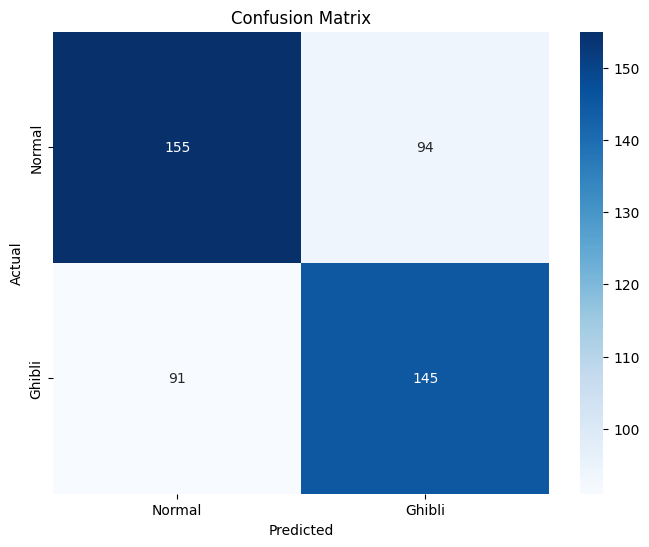


Training SVM model:
Test Accuracy: 0.6289

Classification Report:
              precision    recall  f1-score   support

      Normal       0.64      0.63      0.64       249
      Ghibli       0.62      0.63      0.62       236

    accuracy                           0.63       485
   macro avg       0.63      0.63      0.63       485
weighted avg       0.63      0.63      0.63       485



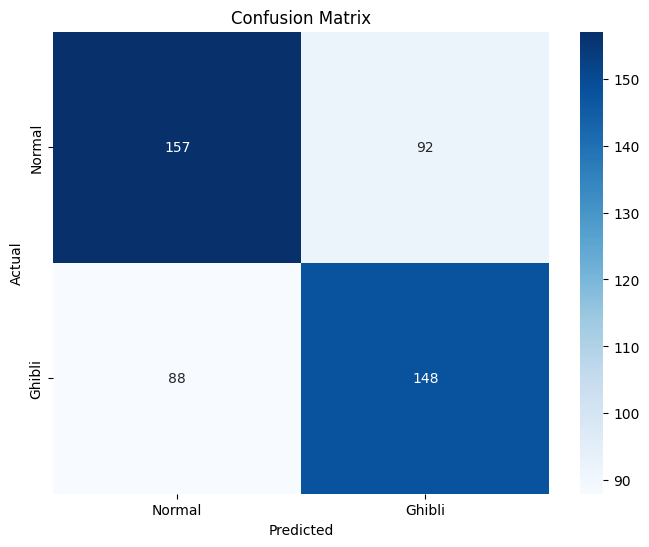


Training Random Forest model:
Test Accuracy: 0.6680

Classification Report:
              precision    recall  f1-score   support

      Normal       0.66      0.73      0.69       249
      Ghibli       0.68      0.61      0.64       236

    accuracy                           0.67       485
   macro avg       0.67      0.67      0.67       485
weighted avg       0.67      0.67      0.67       485



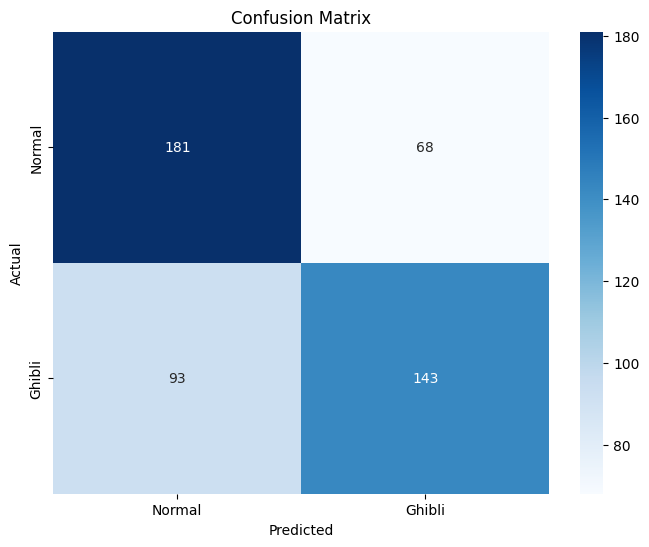


Training XGBoost model:
Test Accuracy: 0.6742

Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.69      0.69       249
      Ghibli       0.67      0.66      0.66       236

    accuracy                           0.67       485
   macro avg       0.67      0.67      0.67       485
weighted avg       0.67      0.67      0.67       485



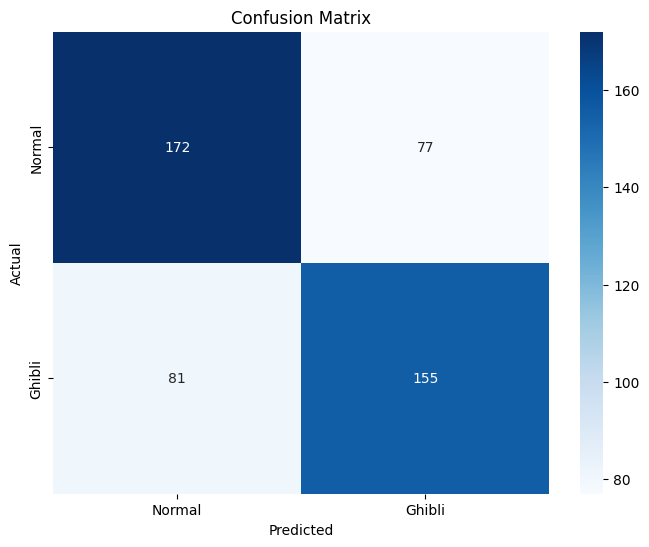

In [77]:
# Train a Logistic Regression model
print("\nTraining Logistic Regression model:")
logistic_regression_model = train_ml_model(features_train, labels_train, model_type='logistic_regression')
evaluate_ml_model(logistic_regression_model, features_test, labels_test)

# Train an SVM model
print("\nTraining SVM model:")
svm_model = train_ml_model(features_train, labels_train, model_type='svm')
evaluate_ml_model(svm_model, features_test, labels_test)

# Train a Random Forest model
print("\nTraining Random Forest model:")
random_forest_model = train_ml_model(features_train, labels_train, model_type='random_forest')
evaluate_ml_model(random_forest_model, features_test, labels_test)

# Train an XGBoost model
print("\nTraining XGBoost model:")
xgboost_model = train_ml_model(features_train, labels_train, model_type='xgboost')
evaluate_ml_model(xgboost_model, features_test, labels_test)

## Too poor a performance to go ahead with ML models